# Miniúkol 1: OVM model

Toto je notebook v jazyce Julia, který obsahuje veškerý kód použitý pro tento miniprojekt.

In [7]:
# načtení potřebných balíčků
using Pkg
Pkg.activate("../SSI")
using Plots, StatsPlots, Distributions, Interact, LaTeXStrings

 Activating environment at `C:\Users\masen\Disk Google\SCHOOL\2020-2021\SSI\miniukol_1\SSI\Project.toml`
   Updating registry at `C:\Users\masen\.julia\registries\General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


  Resolving package versions...
   Updating `C:\Users\masen\Disk Google\SCHOOL\2020-2021\SSI\miniukol_1\SSI\Project.toml`
  [0f1e0344] + WebIO v0.8.15
   Updating `C:\Users\masen\Disk Google\SCHOOL\2020-2021\SSI\miniukol_1\SSI\Manifest.toml`
 [no changes]


In [15]:
Pkg.add("Blink")
Pkg.add("Mux")

  Resolving package versions...
   Updating `C:\Users\masen\Disk Google\SCHOOL\2020-2021\SSI\miniukol_1\SSI\Project.toml`
  [ad839575] + Blink v0.12.3
   Updating `C:\Users\masen\Disk Google\SCHOOL\2020-2021\SSI\miniukol_1\SSI\Manifest.toml`
  [9e28174c] + BinDeps v1.0.1
  [ad839575] + Blink v0.12.3
  [9fb69e20] + Hiccup v0.2.2
  [50d2b5c4] + Lazy v0.15.1
  [ffc61752] + Mustache v1.0.8
  [a975b10e] + Mux v0.7.3
  [30578b45] + URIParser v0.4.1
  Resolving package versions...
   Updating `C:\Users\masen\Disk Google\SCHOOL\2020-2021\SSI\miniukol_1\SSI\Project.toml`
  [a975b10e] + Mux v0.7.3
   Updating `C:\Users\masen\Disk Google\SCHOOL\2020-2021\SSI\miniukol_1\SSI\Manifest.toml`
 [no changes]


## Základní definice

Nejdříve si definujeme hlavní globální proměnné, tedy konstanty modelu atd. Poté už si můžeme zadefinovat, jakým způsobem se bude pohybovat leader celé skupiny, tedy první auto. Zde byla zvolena jako funkce rychlosti

$$v(t) = v_0 + A \sin (Bt)$$

Níže je možné vidět i závislost polohy na čase, rychlosti na poloze a rychlosti na čase.

In [2]:
## GLOBAL VARIABLES ---------------------------------------------------------
Sa = 4
Sav = rand(Uniform(1,5),9)
v_max = 25
d_safe = 25
da = d_safe
db = da*2
v0 = 15
x0 = 0
A = 10
B = 0.5
ymax = v0 + A

25

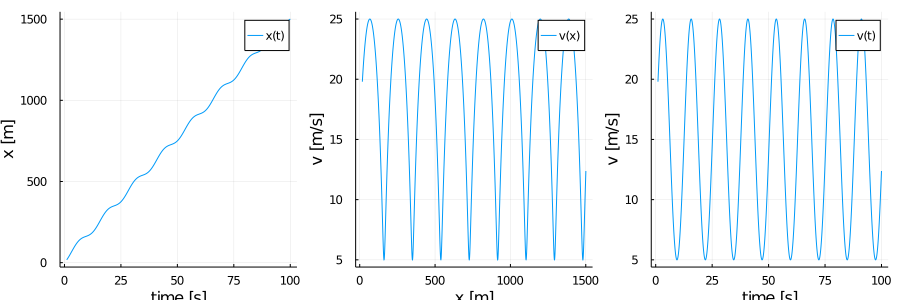

In [3]:
## LEADER ------------------------------------------------------------------
v1(t) = v0 .+ A .* sin.(B .* t)
x1(t) = v0 .* t .- A ./ B .* cos.(B .* t) .+ A / B .+ x0

# nějaké grafíky, jak vypadá rychlost, poloha v čase
tline = 1:0.1:100
vline = v1.(tline)
xline = x1.(tline)

t_vs_x = plot(tline,xline,xlabel="time [s]",ylabel="x [m]",label="x(t)")
x_vs_v = plot(xline,vline,xlabel="x [m]",ylabel="v [m/s]",label="v(x)")
t_vs_v = plot(tline,vline,xlabel="time [s]",ylabel="v [m/s]",label="v(t)")
plot(layout=(1,3),t_vs_x, x_vs_v, t_vs_v,size=(900,300))

Dále definujeme potřebné funkce. První z nich je heaviside $\Theta(x)$, následují jednotlivé funkce pro optimální rychlosti. Pro porovnání těchto funkcí byl vytvořen graf. Aby bylo možné funkce mezi sebou dobře porovnávat, konstanty `da` a `db` byly změněny na jiné hodnoty.

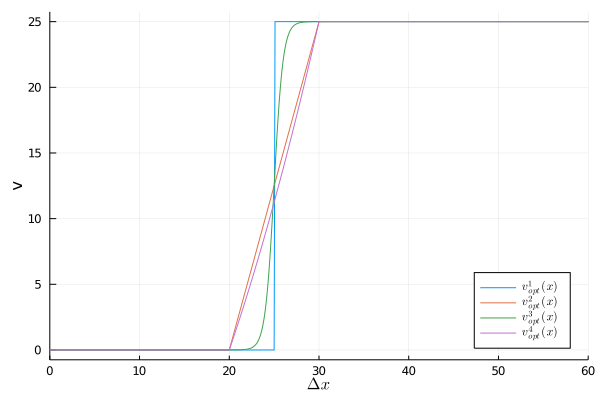

In [4]:
## HEAVISIDE ---------------------------------------------------------------
function heaviside(x)
    if x > 0
        return 1
    else
        return 0
    end
end

## OPTIMÁLNÍ RYCHLOSTI -----------------------------------------------------
v_opt1(x) = v_max .* heaviside.(x .- d_safe)
v1p = plot(v_opt1,xlims=(0,100),label=L"v_{opt}^1(x)",xlabel=L"\Delta x",ylabel="v",
    legend=:bottomright)

function v_opt2(x)
    if x < da
        return 0
    elseif da <= x <= db
        a = v_max/(db-da)
        b = -da*a
        return a*x + b
    else
        return v_max
    end
end

v2p = plot(v_opt2,xlims=(0,100),label=L"v_{opt}^2(x)",xlabel=L"\Delta x",ylabel="v",
    legend=:bottomright)

v_opt3(x) = v_max / 2 * (tanh(x - d_safe) + tanh(d_safe))

v3p = plot(v_opt3,xlims=(0,100),label=L"v_{opt}^2(x)",xlabel=L"\Delta x",ylabel="v",
    legend=:bottomright)

function v_opt4(x)
    if x < da
        return 0
    elseif da <= x <= db
        a = v_max/(db^2-da^2)
        b = -da^2*a
        return a*x^2 + b
    else
        return v_max
    end
end

v4p = plot(v_opt4,xlims=(0,100),label=L"v_{opt}^2(x)",xlabel=L"\Delta x",ylabel="v",
    legend=:bottomright)

da = 20
db = 30
xp = 0:0.1:100
plot(xp,v_opt1.(xp),xlims=(0,100),label=L"v_{opt}^1(x)",xlabel=L"\Delta x",ylabel="v",legend=:bottomright);
plot!(xp,v_opt2.(xp),label=L"v_{opt}^2(x)");
plot!(xp,v_opt3.(xp),label=L"v_{opt}^3(x)");
plot!(xp,v_opt4.(xp),label=L"v_{opt}^4(x)",xlims=(0,60))

Dále definujeme funkci pro zrychlení -- definujeme dvě různé funkce. Jedna počítá s $S_{\alpha}$ jako konstantou, druhá s $S_{\alpha}$ jako vektorem, kde jednotlivé $S_{\alpha}$ jsou henerovány z rozdělení $U(1,5)$.

Nakonec nám zbývá naimplementovat Eulerovu metodu.

In [5]:
# ZRYCHLENÍ -----------------------------------------------------------------
# Sa stejné pro všechny auta
function zrychleni_stejne(v0, va)
    Sa .* (v0 .- va)
end
# Sa různé pro všechny auta
function zrychleni_ruzne(v0, va)
    Sav .* (v0 .- va)
end


## EULEROVA METODA ---------------------------------------------------------
# obecný předpis
function euler(x, v, a)
    v_new = v .+ h .* a
    x_new = x .+ h .* v
    return x_new, v_new
end;

## Inicializace

Pro nastartování experimentu je třeba zvolit několik dalších parametrů, jako je poet vozidel a jejich počáteční vzájemná vzdálenost. Jelikož zde provádíme simulaci pro určitý počet kroků, je třeba nastavit i velikost časového kroku a celkový počet iterací.

In [6]:
## INICIALIZACE ----------------------------------------------------------------------------
n = 10                                      # počet vozidel
Δ = 5                                       # počáteční rozestup mezi vozidly
x0 = Δ * (n - 1)
X = reverse(Float64.(collect(0:Δ:x0)))
V = zeros(10)                               # vektor počátečních rychlostí - zvoleno 0
V[1] = v1(0)                                # přepočet pro v1 (závisí na funkci v1)
t0 = 0                                      # počátek času
h = 0.05                                    # časový krok
iter = 1000                                 # počet iterací
xmax = x1(h*iter)                           # maximální x (pro limity os grafu)
ymax = v0 + A                               # maximální v (pro limity os grafu)
XX = X                                      # ukládání poloh
VV = V;                                     # ukládání rychlostí

In [9]:
width, height = 700, 300
colors = ["black", "gray", "silver", "maroon", "red", "olive", "yellow", "green", "lime", "teal", "aqua", "navy", "blue", "purple", "fuchsia"]
color(i) = colors[i%length(colors)+1]
ui = @manipulate for nsamples in 1:200,
        sample_step in slider(0.01:0.01:1.0, value=0.1, label="sample step"),
        phase in slider(0:0.1:2pi, value=0.0, label="phase"),
        radii in 0.1:0.1:60
    cxs_unscaled = [i*sample_step + phase for i in 1:nsamples]
    cys = sin.(cxs_unscaled) .* height/3 .+ height/2
    cxs = cxs_unscaled .* width/4pi
    dom"svg:svg[width=$width, height=$height]"(
        (dom"svg:circle[cx=$(cxs[i]), cy=$(cys[i]), r=$radii, fill=$(color(i))]"()
            for i in 1:nsamples)...
    )
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["nsamples"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 200,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
100, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\masen\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\masen\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\masen\\.julia\\packages\\InteractBase\\sOe2Z\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\masen\\.julia\\packages\\InteractBase\\sOe2Z\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\masen\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000013b95fb0, Task (runnable) @0x0000000013b95fb0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\"

In [10]:
# volba funkce optimální rychlosti
v_opt = v_opt4

# volba zrychlení: rozdílné nebo stejné
rozdilne_zrychleni = true
if rozdilne_zrychleni
    zrychleni = zrychleni_ruzne
else
    zrychleni = zrychleni_stejne
end

zrychleni_ruzne (generic function with 1 method)

In [11]:
animation = @animate for i in 1:iter
        global t1 = t0 + h

        # v t0 to bude vypadat takto
        Δ_x = diff(hcat(X[2:end], X[1:end - 1]), dims=2)
        vopt = v_opt.(Δ_x)
        a_α = zrychleni(vopt, V[2:end])

        # přechod k t1
        Xn, Vn = euler(X[2:end], V[2:end], a_α)
        global X[2:end] = Xn
        global V[2:end] = Vn
        global X[1] = x1(t1)
        global V[1] = v1(t1)

        # posunutí času a uložení výsledků
        global t0 = t1
        global XX = hcat(XX,X)
        global VV = hcat(VV,V)
        bplot = bar(X,V,bar_width=0.2,xlims = (0,xmax+10),ylims=(0,ymax+2),label="",
        xlabel="x [m]", ylabel="v [m/s]", size=(600,300));
        splot = scatter(X,zeros(n),size=(600,300),label="",ylims=(-0.1,0.1),xlims=(0,xmax+10));
        plot(layout=(2,1),bplot, splot, size=(600,600))
    end;

Animation("C:\\Users\\masen\\AppData\\Local\\Temp\\jl_M9p3IV", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000991.png", "000992.png", "000993.png", "000994.png", "000995.png", "000996.png", "000997.png", "000998.png", "000999.png", "001000.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\masen\Disk Google\SCHOOL\2020-2021\SSI\miniukol_1\SSI\tmp.gif
└ @ Plots C:\Users\masen\.julia\packages\Plots\uCh2y\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\masen\\Disk Google\\SCHOOL\\2020-2021\\SSI\\miniukol_1\\SSI\\tmp.gif")
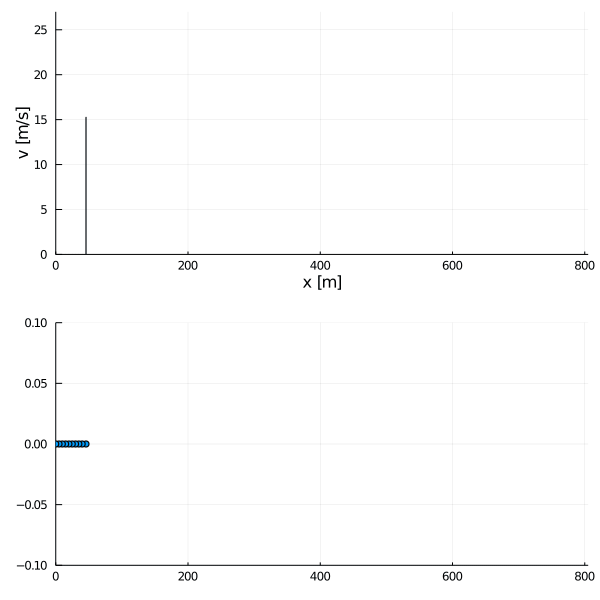

In [13]:
gif(animation)